In [1]:
modelFolder = '../DPrimeCNN/arch_17_1'
datasetFolder = '../Datasets/IITD/2D/'

In [3]:
%matplotlib inline
import sys
sys.path.append('../DPrimeCNN/')
import Utils.datasets as datasets
import Utils.visualization as visualization
import Utils.snapshotter as snapshotter
import Utils.augmentation as dataAugmentation
import Utils.tests as tests
import Models.network as network
import lasagne
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Models.training as training

# Load configurations
print('Loading settings ...')
persistentDb = snapshotter.Snapshotter(modelFolder + '/model.hdf5')
networkCfg = persistentDb.load('config_network')
trainingCfg = persistentDb.load('config_training')
testingCfg = persistentDb.load('config_testing')
networkCfg['arch_name'] = 'Models/Architectures/arch_17'
networkCfg['loss'] = 'dprime'
networkCfg['saliency'] = False

# Get network model
print('Creating network ...')
cnnetwork, cnnlayers, functions = network.getModel(networkCfg)    
    
print('Loaded.')
epochId = 400
print('Params from epoch: {0}'.format(epochId))
modelParamsKey = 'Epoch_%05i_params' % epochId
modelParams = persistentDb.load(modelParamsKey)
print('Params loaded.')

# Load model parameters
print('Setting network parameters ...')
lasagne.layers.set_all_param_values(cnnetwork, modelParams)
print('Done')

Loading settings ...
Opening DB ../DPrimeCNN/arch_17_1/model.hdf5
Creating network ...
Building network... Loading model Models/Architectures/arch_17... Done.
Network:
	Input dimensions (D x W x H): 1 x 128 x 128
	Number of outputs: 32
Compiling functions ... Done.
Available functions:
	'test'
	'train'
	'features'
Loaded.
Params from epoch: 400
Params loaded.
Setting network parameters ...
Done


In [16]:
modelParams = np.array(modelParams)
pars = lasagne.layers.get_all_params(cnnetwork)
print(pars)
for pars in modelParams:
    print(pars.shape)

import struct
def save_layer_params(fileName, params):
    outFile = open(fileName, 'wb')
    cntr = 0
    if type(params) is list:
        for parList in params:
            for par in parList.flatten():
                cntr += 1
                outFile.write(par)
    else:
        flatParams = params.flatten()
        for par in flatParams:
            cntr += 1
            outFile.write(par)
     
    print(cntr)
    outFile.close()

save_layer_params('conv1_W', modelParams[0])
save_layer_params('bn1', np.array([modelParams[1], modelParams[2], modelParams[3], modelParams[4]]))
save_layer_params('conv2_W', [modelParams[5], modelParams[6]])
save_layer_params('conv3_W', [modelParams[7], modelParams[8]])
save_layer_params('conv4_W', [modelParams[9], modelParams[10]])
save_layer_params('fc1_W', [modelParams[11], modelParams[12]])
save_layer_params('fc2_W', [modelParams[13], modelParams[14]])


'''
save_layer_params('conv1_W', modelParams[0])
save_layer_params('bn1', np.array([modelParams[1], modelParams[2], modelParams[3], modelParams[4]]))
save_layer_params('conv2_W', modelParams[5])
save_layer_params('bn2', np.array([modelParams[6], modelParams[7], modelParams[8], modelParams[9]]))
save_layer_params('conv3_W', modelParams[10])
save_layer_params('bn3', np.array([modelParams[11], modelParams[12], modelParams[13], modelParams[14]]))
save_layer_params('conv4_W', modelParams[15])
save_layer_params('bn4', np.array([modelParams[16], modelParams[17], modelParams[18], modelParams[19]]))
save_layer_params('conv5_W', modelParams[20])
save_layer_params('bn5', np.array([modelParams[21], modelParams[22], modelParams[23], modelParams[24]]))
save_layer_params('conv6_W', modelParams[25])
save_layer_params('bn6', np.array([modelParams[26], modelParams[27], modelParams[28], modelParams[29]]))
save_layer_params('conv7_W', [modelParams[30], modelParams[31]])
'''
#pars = np.fromfile('params', 'float32')
#print(pars)

[W, beta, gamma, mean, inv_std, W, b, W, b, W, b, W, b, W, b]
(32, 1, 9, 9)
(32,)
(32,)
(32,)
(32,)
(64, 32, 7, 7)
(64,)
(96, 64, 5, 5)
(96,)
(128, 96, 3, 3)
(128,)
(56448, 256)
(256,)
(256, 32)
(32,)
2592
128
100416
153696
110720
14450944
8224


"\nsave_layer_params('conv1_W', modelParams[0])\nsave_layer_params('bn1', np.array([modelParams[1], modelParams[2], modelParams[3], modelParams[4]]))\nsave_layer_params('conv2_W', modelParams[5])\nsave_layer_params('bn2', np.array([modelParams[6], modelParams[7], modelParams[8], modelParams[9]]))\nsave_layer_params('conv3_W', modelParams[10])\nsave_layer_params('bn3', np.array([modelParams[11], modelParams[12], modelParams[13], modelParams[14]]))\nsave_layer_params('conv4_W', modelParams[15])\nsave_layer_params('bn4', np.array([modelParams[16], modelParams[17], modelParams[18], modelParams[19]]))\nsave_layer_params('conv5_W', modelParams[20])\nsave_layer_params('bn5', np.array([modelParams[21], modelParams[22], modelParams[23], modelParams[24]]))\nsave_layer_params('conv6_W', modelParams[25])\nsave_layer_params('bn6', np.array([modelParams[26], modelParams[27], modelParams[28], modelParams[29]]))\nsave_layer_params('conv7_W', [modelParams[30], modelParams[31]])\n"

44
[996, 598, 953, 450, 929, 367, 908, 289, 1099, 607, 1090, 446, 1085, 339, 1079, 258, 1184, 636, 1239, 485, 1271, 401, 1306, 316, 1279, 706, 1380, 616, 1431, 566, 1483, 522, 999, 886, 922, 809, 843, 739, 805, 664, 1092, 731, 1076, 925]
805
1483
258
925


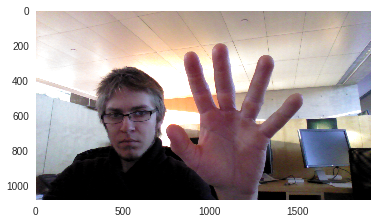

In [14]:
%matplotlib inline
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
import sys
sys.path.append('../Shared/')
import Utils.datasets as datasets

img = sp.misc.imread(os.path.join('../Datasets/Annotated/', '0_0.png')) 

lmksFilePath = os.path.join('../Datasets/Annotated/', '0_0.lmks');
fileLines = []
lmks = []
lmksx = []
lmksy = []
with open(lmksFilePath) as f:
    fileLines = f.read().splitlines()
for aLine in fileLines:
    coords = aLine.split(',')
    lmks.append(int(float(coords[0])))
    lmksx.append(int(float(coords[0])))
    lmks.append(int(float(coords[1])))
    lmksy.append(int(float(coords[1])))
print(len(lmks))
print(lmks)
print(np.min(lmksx))
print(np.max(lmksx))
print(np.min(lmksy))
print(np.max(lmksy))

sns.set_style('dark')
plt.imshow(img)
plt.figure()

In [ ]:
# Local image normalization test
#datasetFolder = '../Casia_Filt/Merged/'
%matplotlib inline
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
import sys
sys.path.append('../Shared/')
import Utils.datasets as datasets

def rgb2gray(rgb):
    return 0.299 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.144 * rgb[:, :, 2]
    #return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def localNormalize(img, mean, std, eps = 0.1):                                                                                                            
        meanVals = sp.ndimage.gaussian_filter(img, mean)                                                                                       
        imgCent = img - meanVals                                                                                                               
        stdVals = np.sqrt(sp.ndimage.gaussian_filter(imgCent**2, std))                                                                         
        return imgCent / (stdVals + eps)               

def extractROI(image, roiSize = 512, normalize = True):
    # Convert to grayscale
    img = rgb2gray(image)
    # Binarize the image
    imgBin = img.copy()
    imgBin[img > 100] = 255
    imgBin[img < 100] = 0
    # Find palm region of the image
    imgBinTmp = sp.misc.imresize(imgBin.copy(), (150, 200))
    morphSelem = morphology.disk(30)
    imgBinTmp = morphology.binary_opening(imgBinTmp, morphSelem)
    imgBinTmp = sp.misc.imresize(imgBinTmp, (1200, 1600))
    # Compute distance transform
    imgDT = sp.ndimage.morphology.distance_transform_edt(imgBinTmp)
    # Find position of maximum of distance transform in the image
    maxpx, maxpy = imgDT.argmax() % imgBin.shape[1], imgDT.argmax() / imgBin.shape[1]
    # Compute palm region coords
    regHalf = roiSize / 2
    yShift = 0#roiSize / 8
    minry, maxry = maxpy - regHalf - yShift, maxpy + regHalf - yShift
    minrx, maxrx = maxpx - regHalf, maxpx + regHalf
    # Check palm region coords bounds within the image
    if minry < 0:
        maxry = maxry + abs(minry)
        minry = 0
    if maxry > img.shape[0]:
        minry = minry - (maxry - img.shape[0])
        maxry = img.shape[0]
    if minrx < 0:
        maxrx = maxrx + abs(minrx)
        minrx = 0
    if maxrx > img.shape[1]:
        minrx = minrx - (maxrx - img.shape[1])
        maxrx = img.shape[1]
    # Extract the palm region
    imgPalm = img[minry:maxry, minrx:maxrx]
    imgPalmBin = imgBin[minry:maxry, minrx:maxrx]
    # Threshold palm
    img = img / np.float32(256) 
    imgNorm = np.copy(imgPalm)
    if normalize:
        imgNorm = localNormalize(imgNorm, 5, 35, eps = 1.0) 
    imgNorm = (imgNorm - imgNorm.min()) / (imgNorm.max() - imgNorm.min())
    imgNorm[imgPalmBin == 0] = 0

    return imgNorm

# Load an RGB image
i = 4
for i in range(6):
#if True:
    img = sp.misc.imread(os.path.join('../Datasets/IITD/2D_Full/Left Hand/', '007_' + str(i+1) + '.JPG')) 
    print(os.path.join('../Datasets/IITD/2D_Full/Left Hand/', '039_' + str(i+1) + '.JPG'))
    #imgNorm = extractROI(img, roiSize = 512)
    
    # Convert to grayscale
    img = rgb2gray(img)
    # Binarize the image
    imgBin = img.copy()
    imgBin[imgBin > 100] = 255
    imgBin[imgBin < 100] = 0
    # Find palm region of the image
    imgBinTmp = sp.misc.imresize(imgBin.copy(), (150, 200))
    morphSelem = morphology.disk(15)
    imgBinTmp = morphology.binary_opening(imgBinTmp, morphSelem)
    imgBinTmp = sp.misc.imresize(imgBinTmp, (1200, 1600))
    # Compute distance transform
    imgDT = sp.ndimage.morphology.distance_transform_edt(imgBinTmp)
    # Find position of maximum of distance transform in the image
    maxpx, maxpy = imgDT.argmax() % imgBin.shape[1], imgDT.argmax() / imgBin.shape[1]
    # Compute palm region coords
    regHalf = 256
    yShift = 0#roiSize / 8
    minry, maxry = maxpy - regHalf - yShift, maxpy + regHalf - yShift
    minrx, maxrx = maxpx - regHalf, maxpx + regHalf
    # Extract the palm region
    img = img / np.float32(256) 
    #img = ((img - img.min()) * 2.0) / (img.max() - img.min()) - 1.0
    imgPalm = img[minry:maxry, minrx:maxrx]  
    imgPalmBin = imgBin[minry:maxry, minrx:maxrx]
    #imgPalm = (imgPalm - imgPalm.min()) / (imgPalm.max() - imgPalm.min())
    #imgPalm = filters.rank.median(imgPalm, morphology.disk(1))
    imgNorm = np.copy(imgPalm)
    #imgNorm = filters.rank.median(imgNorm, morphology.disk(1))
    imgNorm = localNormalize(imgNorm, 5, 35, eps = 1.0) 
    #imgNorm = filters.rank.median(imgNorm, morphology.disk(1))
    imgNorm = (imgNorm - imgNorm.min()) / (imgNorm.max() - imgNorm.min())
    noise = np.random.random(imgNorm.shape)
    imgNorm[imgPalmBin == 0] = 1.0#noise[imgPalmBin == 0]
    #imgNorm = 1.0 - imgNorm

    #imgNorm = sp.misc.imresize(imgNorm, (192, 192))

    sns.set_style('dark')
    plt.imshow(imgBin)
    plt.set_cmap('gray')
    plt.colorbar()
    plt.figure()



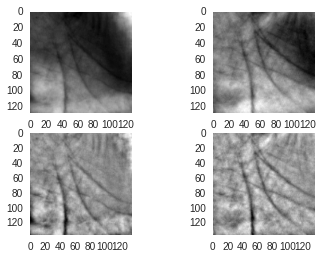

In [48]:
# Local image normalization test
%matplotlib inline
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../Shared/')
import Utils.datasets as datasets
    
def localNormalize(img, mean, std, eps = 0.1):
    meanVals = sp.ndimage.gaussian_filter(img, mean)
    imgCent = img - meanVals
    stdVals = np.sqrt(sp.ndimage.gaussian_filter(imgCent**2, std))
    return imgCent / (stdVals + eps)

targetDim = (136, 136)

img1 = sp.misc.imread(os.path.join('../Datasets/HKPoly/2D/001_F/01.bmp')) 
anImage1 = sp.misc.imresize(img1, targetDim)
anImage1 = anImage1 / np.float32(256)
anImage1 = localNormalize(anImage1, 7, 7, eps = 1.0)

img2 = sp.misc.imread(os.path.join('../Datasets/HKPoly/2D/001_S/05.bmp')) 
anImage2 = sp.misc.imresize(img2, targetDim)
anImage2 = anImage2 / np.float32(256)
anImage2 = localNormalize(anImage2, 7, 7, eps = 1.0)

    
fig = plt.figure()
sns.set_style('dark')
plt.set_cmap('gray')
#plt.colorbar()
fig.add_subplot(221)
plt.imshow(img1)
fig.add_subplot(222)
plt.imshow(img2)
fig.add_subplot(223)
plt.imshow(anImage1)
fig.add_subplot(224)
plt.imshow(anImage2)


../Datasets/IITD/2D_Full/Left_Hand/039_1.JPG
[ 0.91332658  0.40722789]
0.419416825921
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_2.JPG
[ 0.9601331   0.27954325]
0.283318357585
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_3.JPG
[ 0.85565827  0.51754123]
0.543974907759
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_4.JPG
[ 0.93742572  0.34818532]
0.355634592163
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_5.JPG
[ 0.98714041 -0.15985557]
0.160544341937
(512, 512)


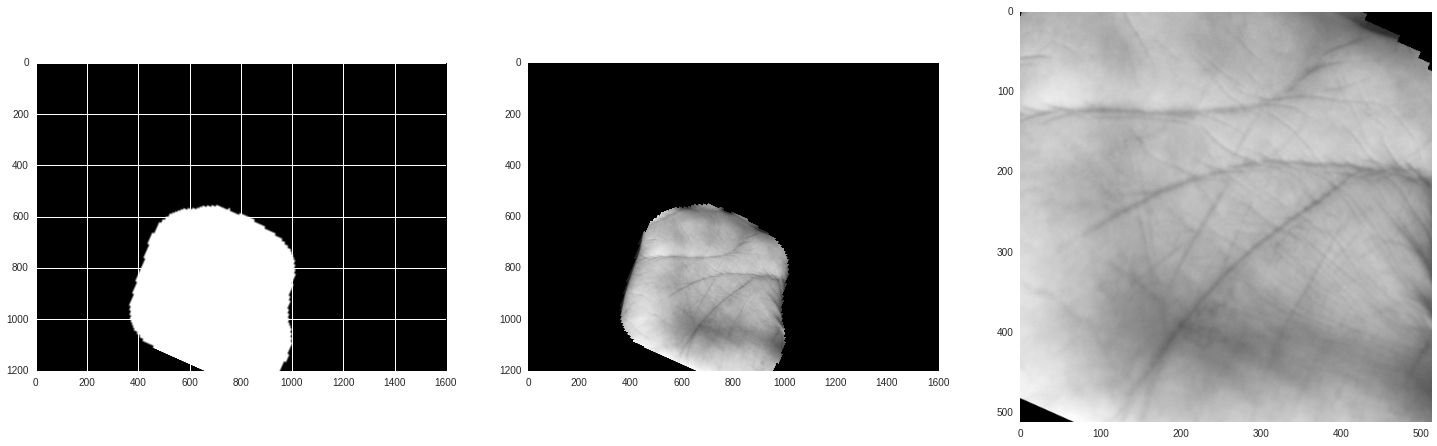

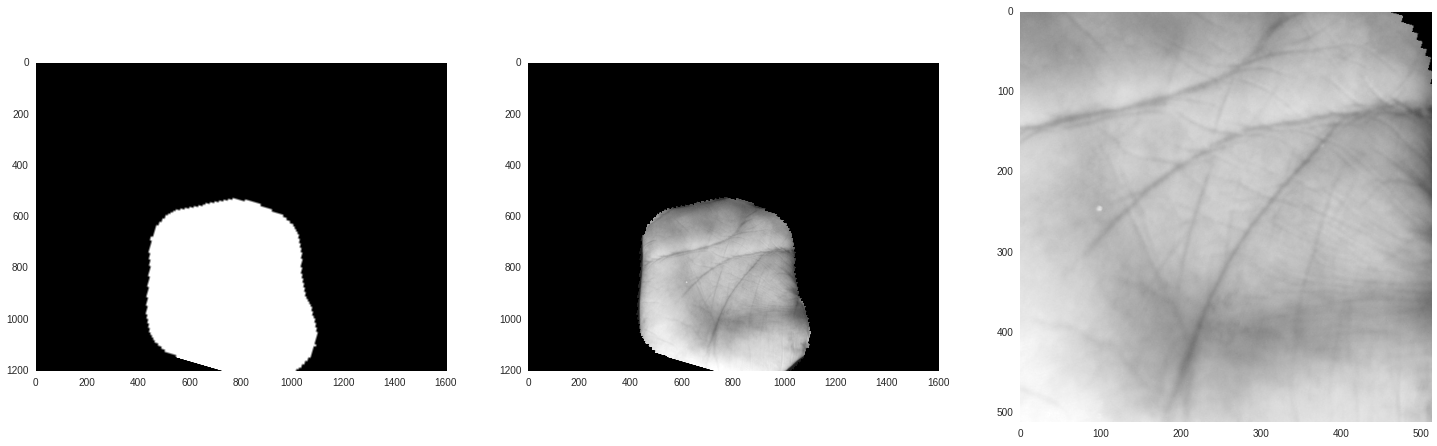

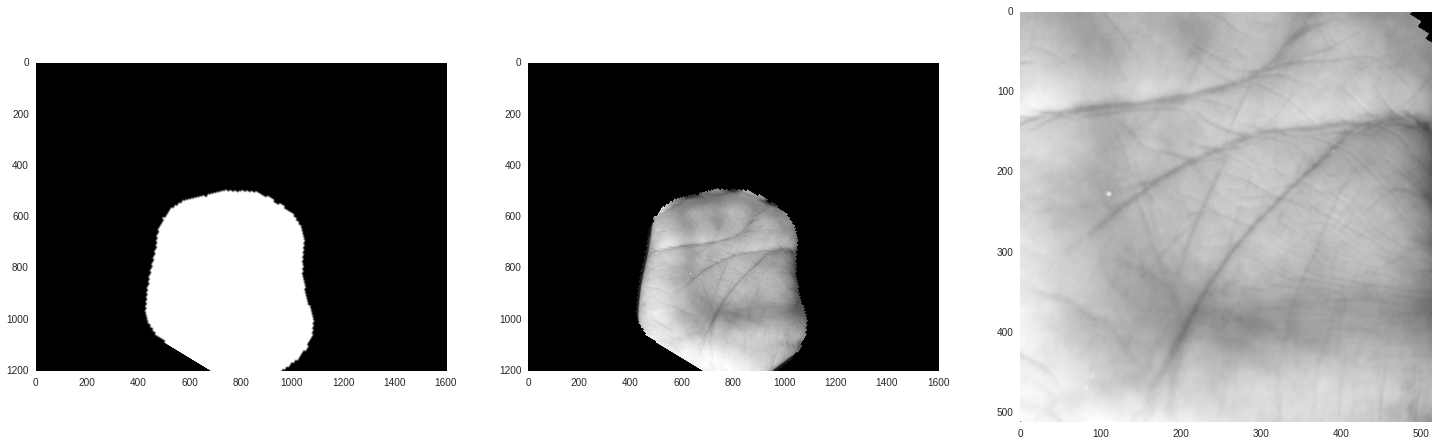

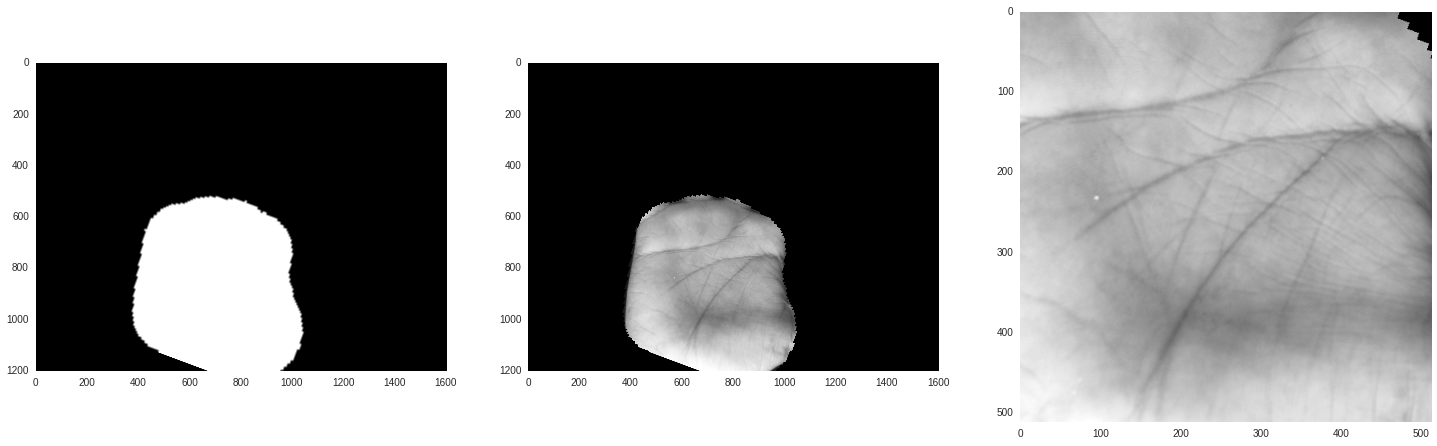

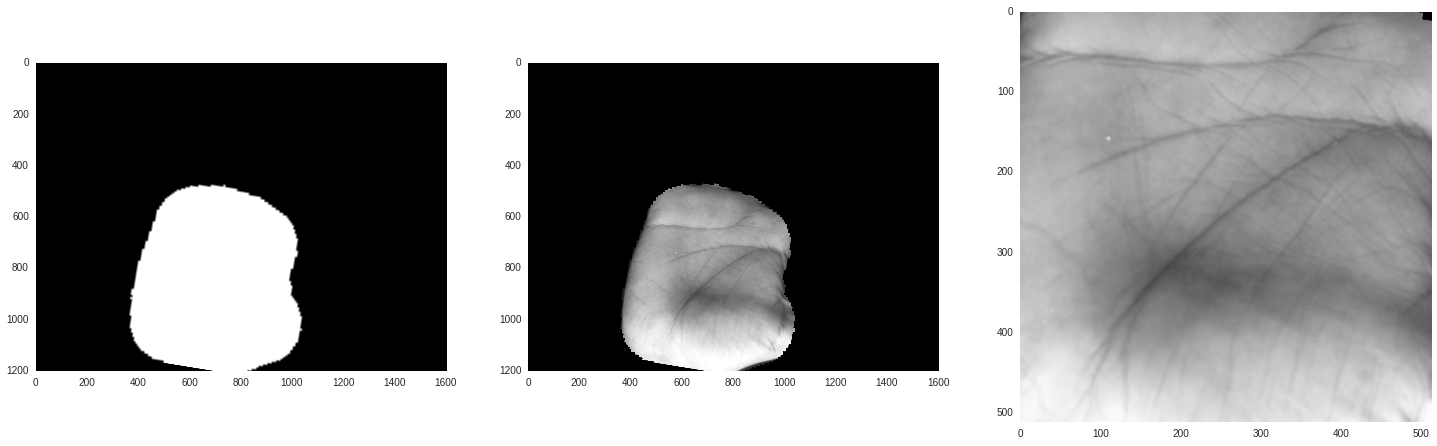

In [1]:
# Local image normalization test
#datasetFolder = '../Casia_Filt/Merged/'
%matplotlib inline
import os
import math
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import transform
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from sklearn.decomposition import PCA
import sys
sys.path.append('../Shared/')
import Utils.datasets as datasets

def rgb2gray(rgb):
    return (0.299 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.114 * rgb[:, :, 2]).astype(np.uint8)
    #return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def extractMask(rgb):
    mask = rgb[:, :, 0] - rgb[:, :, 2] / 2
    thresh = filters.threshold_otsu(mask)
    mask[mask >= thresh] = 255
    mask[mask < thresh] = 0
    mask = morphology.binary_dilation(mask, morphology.disk(3))
    mask = morphology.binary_erosion(mask, morphology.disk(7))
    return mask
    
def localNormalize(img, mean, std, eps = 0.1):                                                                                                            
        meanVals = sp.ndimage.gaussian_filter(img, mean)                                                                                       
        imgCent = img - meanVals                                                                                                               
        stdVals = np.sqrt(sp.ndimage.gaussian_filter(imgCent**2, std))                                                                         
        return imgCent / (stdVals + eps)               

# Load an RGB image
i = 4
for i in range(5):
#if True:
    img = sp.misc.imread(os.path.join('../Datasets/IITD/2D_Full/Left_Hand/', '039_' + str(i+1) + '.JPG')) 
    print(os.path.join('../Datasets/IITD/2D_Full/Left_Hand/', '039_' + str(i+1) + '.JPG'))
    #imgNorm = extractROI(img, roiSize = 512)
       
    # Get mask
    imgBin = extractMask(img)
    imgBin = imgBin.astype(np.float)
    # Convert to grayscale
    img = rgb2gray(img)
    img = img.astype(np.float)

    # Find palm region of the image
    imgBinTmp = sp.misc.imresize(imgBin.copy(), (150, 200))
    morphSelem = morphology.disk(20)
    imgBinTmp = morphology.binary_opening(imgBinTmp, morphSelem)
    imgBinTmp = sp.misc.imresize(imgBinTmp, (1200, 1600))
        
    # Compute image rotation
    '''
    m = measure.moments(imgBin)
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    mu = measure.moments_central(imgBin, cr, cc)
    mu2002 = mu[2, 0] - mu[0, 2]
    theta = 0.5 * math.atan((2.0 * mu[1, 1]) / mu2002)
    if mu[1, 1] >= 0 and mu2002 < 0:
        theta += np.pi / 2.0
    elif mu[1, 1] > 0 and mu2002 == 0:
        theta += np.pi / 4.0
    elif mu[1, 1] < 0 and mu2002 == 0:
        theta -= np.pi / 4.0
    elif mu[1, 1] < 0 and mu2002 < 0:
        theta -= np.pi / 2.0
    if theta < 0:
        theta =  theta + np.pi
    theta = -np.pi/2.0 + theta
    '''
    indices = np.nonzero(imgBin)
    pts = []
    for idx in range(len(indices[0])):
        pts.append([indices[0][idx], indices[1][idx]])
    pca = PCA(n_components = 2)
    pca.fit(pts)
    print(pca.components_[0])
    print(np.arccos(np.dot([1, 0], pca.components_[0])))
    theta = np.pi * 2 - np.arccos(np.dot([1, 0], pca.components_[0]))

    # Compute palm region coords
    regHalf = 256
    iy, ix = np.meshgrid(np.linspace(0, 1599, 1600), np.linspace(0, 1199, 1200))
    iy = iy.astype(np.int32)
    ix = ix.astype(np.int32)
    
    #minry = np.min(ix[imgBinTmp == 255]) + 60
    #maxry = minry + regHalf * 2 
    
    #minrx = np.min(iy[imgBinTmp == 255])
    #maxrx = np.max(iy[imgBinTmp == 255])
    #rangex = maxrx - minrx
    
    #shifty = (rangex - (regHalf * 2)) / 2
    #minry = np.min(ix[imgBinTmp == 255]) + shifty
    #maxry = minry + regHalf * 2
    
    #cenrx = (np.max(iy[imgBinTmp == 255]) + np.min(iy[imgBinTmp == 255])) / 2
    #cenrx = cenrx - 40
    #cenry = minry + regHalf
    #minrx, maxrx = cenrx - regHalf, cenrx + regHalf
    
    minry = np.min(ix[imgBinTmp > 0])
    maxry = np.max(ix[imgBinTmp > 0]) 
    minrx = np.min(iy[imgBinTmp > 0])
    maxrx = np.max(iy[imgBinTmp > 0])
    
    cenrx = minrx + (maxrx - minrx) / 2
    cenry = minry + (maxry - minry) / 2
    
    # Rotate the image
    img = transform.rotate(img, theta * 180 / np.pi, center = (cenrx, cenry))
    imgBin = transform.rotate(imgBin, theta * 180 / np.pi, center = (cenrx, cenry))
    imgBinTmp = transform.rotate(imgBinTmp, theta * 180 / np.pi, center = (cenrx, cenry))
    
    minry = np.min(ix[imgBinTmp > 0])
    maxry = np.max(ix[imgBinTmp > 0]) 
    minrx = np.min(iy[imgBinTmp > 0])
    maxrx = np.max(iy[imgBinTmp > 0])
    
    #cenrx = minrx + (maxrx - minrx) / 2
    #cenry = minry + (maxry - minry) / 2
    
    # Extract the palm region
    img = img / np.float32(256) 
    
    imgMasked = img
    imgMasked[imgBinTmp == 0] = 0
    
    rs = 256
    imgPalm = img[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]  
    imgPalmBin = imgBin[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]
    imgPalmMasked = imgMasked[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]
    #imgPalm = img[minry:maxry, minrx:maxrx]  
    #imgPalmBin = imgBin[minry:maxry, minrx:maxrx]
    imgNorm = np.copy(imgPalm)
    imgNorm = localNormalize(imgNorm, 5, 35, eps = 1.0) 
    # Remove eventual spikes before normalizing into 0.0 - 1.0
    if(len(imgNorm[imgNorm > imgNorm.max() - 0.1]) < 500):
        imgPalmBin[imgNorm > imgNorm.max() - 0.1] = 0
    # Normalize into range 0.0 - 1.0 and mask borders
    imgNorm[imgPalmBin != 0] = (imgNorm[imgPalmBin != 0] - imgNorm[imgPalmBin != 0].min()) / (imgNorm[imgPalmBin != 0].max() - imgNorm[imgPalmBin != 0].min() + 1e-3)
    imgNorm[imgPalmBin == 0] = 0.0
    #rs = 256
    #cenry -= minry
    #cenrx -= minrx
    #imgNorm = imgNorm[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]  
    #imgNorm = sp.misc.imresize(imgNorm, (192, 192))    
    
    print(imgNorm.shape)
    plt.figure(figsize = (25, 25))
    plt.subplot(1, 3, 1)
    sns.set_style('dark')
    plt.imshow(imgBinTmp)
    plt.set_cmap('gray')
    #plt.colorbar()
    plt.subplot(1, 3, 2)
    sns.set_style('dark')
    plt.imshow(imgMasked)
    plt.set_cmap('gray')
    #plt.colorbar()
    plt.subplot(1, 3, 3)
    sns.set_style('dark')
    plt.imshow(imgPalmMasked)
    plt.set_cmap('gray')
    #plt.colorbar()



In [ ]:
import numpy as np
import scipy as sp
import sys
import os
sys.path.append('../Shared/')
import Utils.datasets as datasets
import Utils.augmentation as augmentation
%matplotlib inline
import math
import seaborn as sns
import matplotlib.pyplot as plt


datasetPath = '../Datasets/IITD/2D_Full/Left Hand/'
destPath = './Try/'

# get all folders in the current directory
fileList = os.listdir(datasetPath)
fileList.sort()
# for each directory, extract the label and load images
for aFile in fileList:
        filePath = os.path.join(datasetPath, aFile)
        # we care only about files, only .bmp
        if os.path.isfile(filePath) and os.path.splitext(filePath)[1] == '.JPG':
                # skip the label if it is in exclude list
                aLabel = int(aFile[:3])
                aLabel = aLabel - 1
                # extract label
                print('Current label: {0}'.format(aLabel))
                # read image and add to array of images
                anImage = sp.misc.imread(filePath)
                anImage = datasets.rgb2gray(anImage)
                imgs = augmentation.shift2d(anImage, cropSize = 40, step = 10)
                for img in imgs:
                    sns.set_style('dark')
                    plt.imshow(img)
                    plt.set_cmap('gray')
                    plt.colorbar()
                    plt.figure()
                
                #anImage = datasets.extractROI(anImage, roiSize = 448)
                #fileName = aFile[:5] + '.bmp'
                # Add dimension specifying numbef or channels
                #sp.misc.imsave(os.path.join(destPath, fileName), anImage)



../Datasets/IITD/2D_Full/Left_Hand/039_1.JPG
[ 0.91332658  0.40722789]
0.419416825921
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_2.JPG
[ 0.9601331   0.27954325]
0.283318357585
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_3.JPG
[ 0.85565827  0.51754123]
0.543974907759
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_4.JPG
[ 0.93742572  0.34818532]
0.355634592163
(512, 512)
../Datasets/IITD/2D_Full/Left_Hand/039_5.JPG
[ 0.98714041 -0.15985557]
0.160544341937
(512, 512)


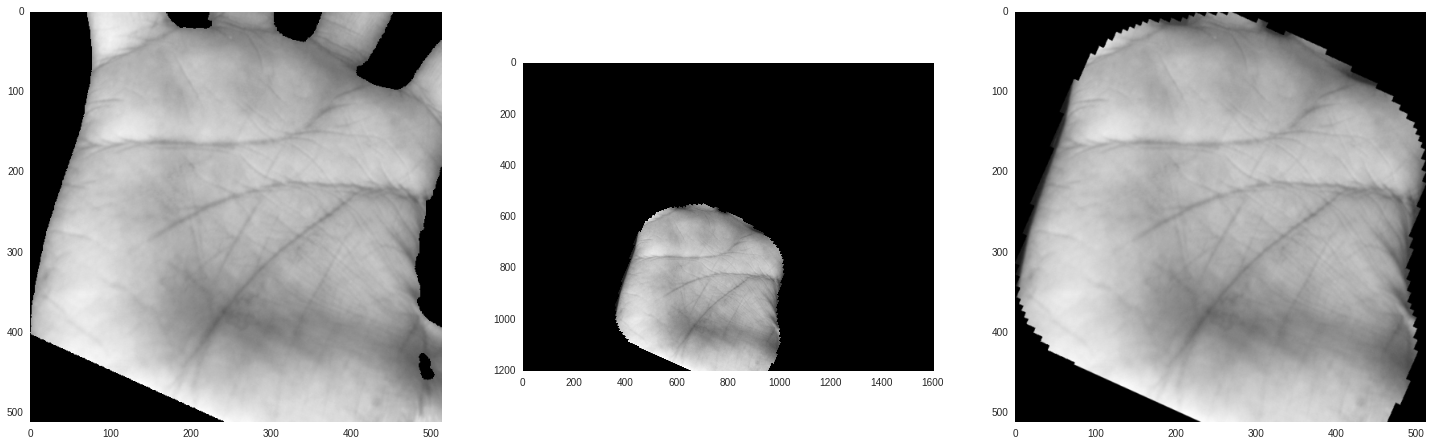

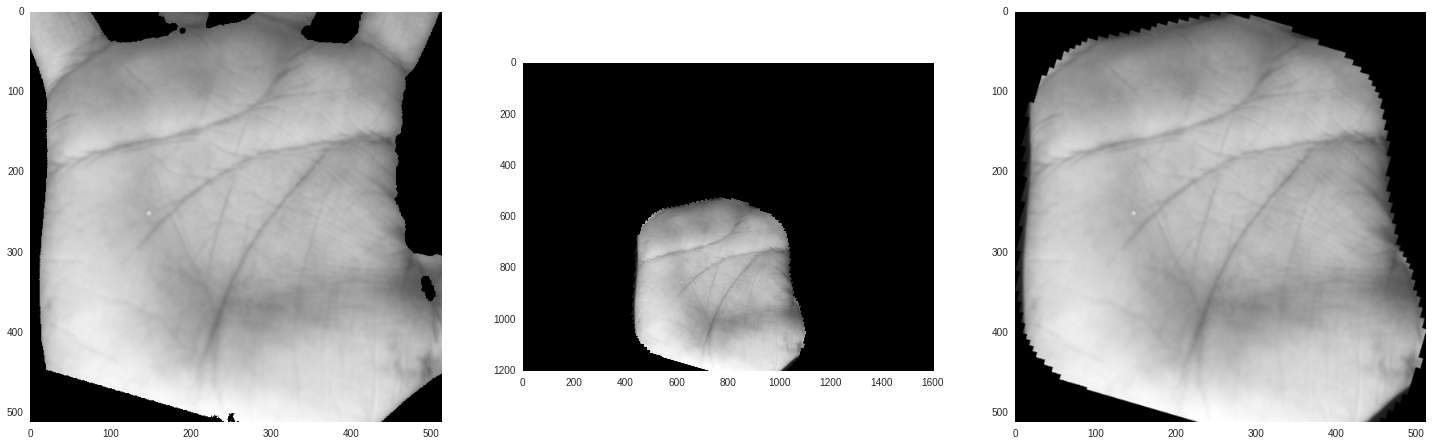

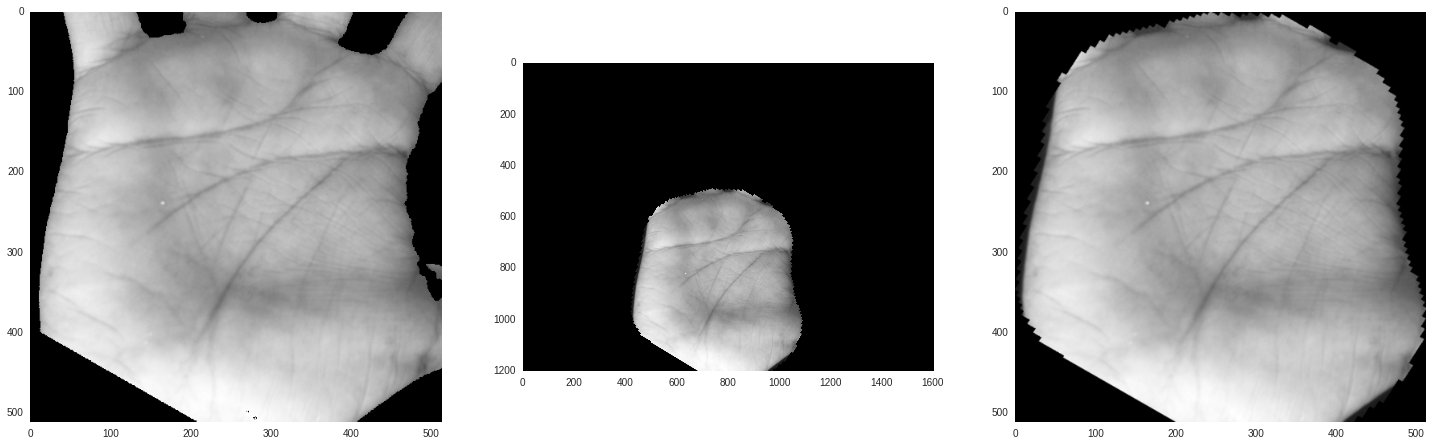

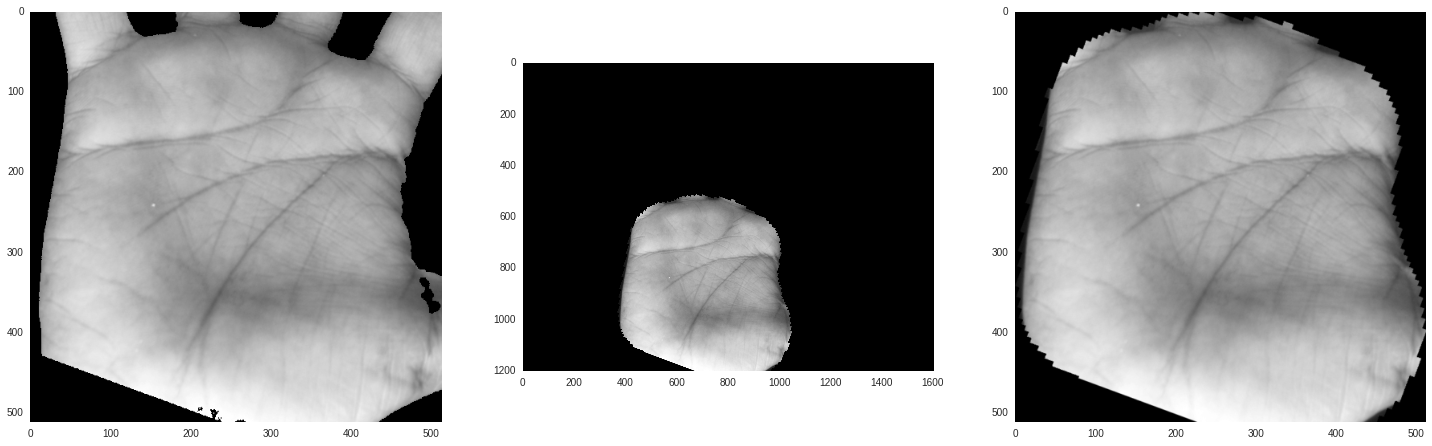

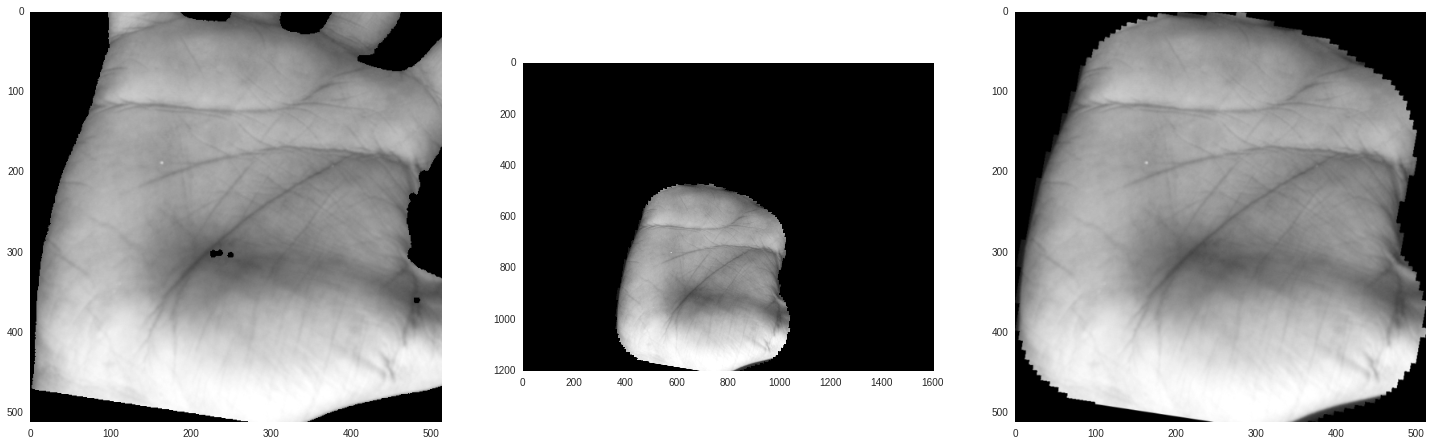

In [14]:
# Local image normalization test
#datasetFolder = '../Casia_Filt/Merged/'
%matplotlib inline
import os
import math
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import transform
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from sklearn.decomposition import PCA
import sys
sys.path.append('../Shared/')
import Utils.datasets as datasets

def rgb2gray(rgb):
    return (0.299 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.114 * rgb[:, :, 2]).astype(np.uint8)
    #return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def extractMask(rgb):
    mask = rgb[:, :, 0] - rgb[:, :, 2] / 2
    thresh = filters.threshold_otsu(mask)
    mask[mask >= thresh] = 255
    mask[mask < thresh] = 0
    mask = morphology.binary_dilation(mask, morphology.disk(3))
    mask = morphology.binary_erosion(mask, morphology.disk(7))
    return mask
    
def localNormalize(img, mean, std, eps = 0.1):                                                                                                            
        meanVals = sp.ndimage.gaussian_filter(img, mean)                                                                                       
        imgCent = img - meanVals                                                                                                               
        stdVals = np.sqrt(sp.ndimage.gaussian_filter(imgCent**2, std))                                                                         
        return imgCent / (stdVals + eps)               

# Load an RGB image
i = 4
for i in range(5):
#if True:
    img = sp.misc.imread(os.path.join('../Datasets/IITD/2D_Full/Left_Hand/', '039_' + str(i+1) + '.JPG')) 
    print(os.path.join('../Datasets/IITD/2D_Full/Left_Hand/', '039_' + str(i+1) + '.JPG'))
    #imgNorm = extractROI(img, roiSize = 512)
       
    # Get mask
    imgBin = extractMask(img)
    imgBin = imgBin.astype(np.float)
    # Convert to grayscale
    img = rgb2gray(img)
    img = img.astype(np.float)

    # Find palm region of the image
    imgBinTmp = sp.misc.imresize(imgBin.copy(), (150, 200))
    morphSelem = morphology.disk(20)
    imgBinTmp = morphology.binary_opening(imgBinTmp, morphSelem)
    imgBinTmp = sp.misc.imresize(imgBinTmp, (1200, 1600))
        
    # Compute image rotation
    '''
    m = measure.moments(imgBin)
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    mu = measure.moments_central(imgBin, cr, cc)
    mu2002 = mu[2, 0] - mu[0, 2]
    theta = 0.5 * math.atan((2.0 * mu[1, 1]) / mu2002)
    if mu[1, 1] >= 0 and mu2002 < 0:
        theta += np.pi / 2.0
    elif mu[1, 1] > 0 and mu2002 == 0:
        theta += np.pi / 4.0
    elif mu[1, 1] < 0 and mu2002 == 0:
        theta -= np.pi / 4.0
    elif mu[1, 1] < 0 and mu2002 < 0:
        theta -= np.pi / 2.0
    if theta < 0:
        theta =  theta + np.pi
    theta = -np.pi/2.0 + theta
    '''
    indices = np.nonzero(imgBin)
    pts = []
    for idx in range(len(indices[0])):
        pts.append([indices[0][idx], indices[1][idx]])
    pca = PCA(n_components = 2)
    pca.fit(pts)
    print(pca.components_[0])
    print(np.arccos(np.dot([1, 0], pca.components_[0])))
    theta = np.pi * 2 - np.arccos(np.dot([1, 0], pca.components_[0]))

    # Compute palm region coords
    regHalf = 256
    iy, ix = np.meshgrid(np.linspace(0, 1599, 1600), np.linspace(0, 1199, 1200))
    iy = iy.astype(np.int32)
    ix = ix.astype(np.int32)
    
    #minry = np.min(ix[imgBinTmp == 255]) + 60
    #maxry = minry + regHalf * 2 
    
    #minrx = np.min(iy[imgBinTmp == 255])
    #maxrx = np.max(iy[imgBinTmp == 255])
    #rangex = maxrx - minrx
    
    #shifty = (rangex - (regHalf * 2)) / 2
    #minry = np.min(ix[imgBinTmp == 255]) + shifty
    #maxry = minry + regHalf * 2
    
    #cenrx = (np.max(iy[imgBinTmp == 255]) + np.min(iy[imgBinTmp == 255])) / 2
    #cenrx = cenrx - 40
    #cenry = minry + regHalf
    #minrx, maxrx = cenrx - regHalf, cenrx + regHalf
    
    minry = np.min(ix[imgBinTmp > 0])
    maxry = np.max(ix[imgBinTmp > 0]) 
    minrx = np.min(iy[imgBinTmp > 0])
    maxrx = np.max(iy[imgBinTmp > 0])
    
    cenrx = minrx + (maxrx - minrx) / 2
    cenry = minry + (maxry - minry) / 2
    
    # Rotate the image
    img = transform.rotate(img, theta * 180 / np.pi, center = (cenrx, cenry))
    imgBin = transform.rotate(imgBin, theta * 180 / np.pi, center = (cenrx, cenry))
    imgBinTmp = transform.rotate(imgBinTmp, theta * 180 / np.pi, center = (cenrx, cenry))
    
    minry = np.min(ix[imgBinTmp > 0])
    maxry = np.max(ix[imgBinTmp > 0]) 
    minrx = np.min(iy[imgBinTmp > 0])
    maxrx = np.max(iy[imgBinTmp > 0])
    
    #cenrx = minrx + (maxrx - minrx) / 2
    #cenry = minry + (maxry - minry) / 2
    
    # Extract the palm region
    img = img / np.float32(256) 
    
    imgMasked = img.copy()
    imgMasked[imgBinTmp == 0] = 0
    
    rs = 256
    #imgPalm = img[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]  
    #imgPalmBin = imgBin[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]
    #imgPalmMasked = imgMasked[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]
    imgPalm = img[minry:maxry, minrx:maxrx]  
    imgPalmBin = imgBin[minry:maxry, minrx:maxrx]
    imgPalmMasked = imgMasked[minry:maxry, minrx:maxrx]
    imgPalm = sp.misc.imresize(imgPalm, (512, 512))
    imgPalmBin = sp.misc.imresize(imgPalmBin, (512, 512))
    imgPalmMasked = sp.misc.imresize(imgPalmMasked, (512, 512))
    #imgPalm = img[minry:maxry, minrx:maxrx]  
    #imgPalmBin = imgBin[minry:maxry, minrx:maxrx]
    imgNorm = np.copy(imgPalm)
    #imgNorm = localNormalize(imgNorm, 5, 35, eps = 1.0) 
    # Remove eventual spikes before normalizing into 0.0 - 1.0
    if(len(imgNorm[imgNorm > imgNorm.max() - 0.1]) < 500):
        imgPalmBin[imgNorm > imgNorm.max() - 0.1] = 0
    # Normalize into range 0.0 - 1.0 and mask borders
    #imgNorm[imgPalmBin != 0] = (imgNorm[imgPalmBin != 0] - imgNorm[imgPalmBin != 0].min()) / (imgNorm[imgPalmBin != 0].max() - imgNorm[imgPalmBin != 0].min() + 1e-3)
    imgNorm[imgPalmBin == 0] = 0.0
    #rs = 256
    #cenry -= minry
    #cenrx -= minrx
    #imgNorm = imgNorm[cenry - rs:cenry + rs, cenrx - rs:cenrx + rs]  
    #imgNorm = sp.misc.imresize(imgNorm, (192, 192))    
    
    print(imgNorm.shape)
    plt.figure(figsize = (25, 25))
    plt.subplot(1, 3, 1)
    sns.set_style('dark')
    plt.imshow(imgNorm)
    plt.set_cmap('gray')
    #plt.colorbar()
    plt.subplot(1, 3, 2)
    sns.set_style('dark')
    plt.imshow(imgMasked)
    plt.set_cmap('gray')
    #plt.colorbar()
    plt.subplot(1, 3, 3)
    sns.set_style('dark')
    plt.imshow(imgPalmMasked)
    plt.set_cmap('gray')
    #plt.colorbar()

